# Machine Learning Engineer Nanodegree
## Reinforcement Learning
## Project: Train a Smartcab to Drive

Welcome to the fourth project of the Machine Learning Engineer Nanodegree! In this notebook, template code has already been provided for you to aid in your analysis of the *Smartcab* and your implemented learning algorithm. You will not need to modify the included code beyond what is requested. There will be questions that you must answer which relate to the project and the visualizations provided in the notebook. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide in `agent.py`.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

-----

## Getting Started
In this project, you will work towards constructing an optimized Q-Learning driving agent that will navigate a *Smartcab* through its environment towards a goal. Since the *Smartcab* is expected to drive passengers from one location to another, the driving agent will be evaluated on two very important metrics: **Safety** and **Reliability**. A driving agent that gets the *Smartcab* to its destination while running red lights or narrowly avoiding accidents would be considered **unsafe**. Similarly, a driving agent that frequently fails to reach the destination in time would be considered **unreliable**. Maximizing the driving agent's **safety** and **reliability** would ensure that *Smartcabs* have a permanent place in the transportation industry.

**Safety** and **Reliability** are measured using a letter-grade system as follows:

| Grade 	| Safety 	| Reliability 	|
|:-----:	|:------:	|:-----------:	|
|   A+  	|  Agent commits no traffic violations,<br/>and always chooses the correct action. | Agent reaches the destination in time<br />for 100% of trips. |
|   A   	|  Agent commits few minor traffic violations,<br/>such as failing to move on a green light. | Agent reaches the destination on time<br />for at least 90% of trips. |
|   B   	| Agent commits frequent minor traffic violations,<br/>such as failing to move on a green light. | Agent reaches the destination on time<br />for at least 80% of trips. |
|   C   	|  Agent commits at least one major traffic violation,<br/> such as driving through a red light. | Agent reaches the destination on time<br />for at least 70% of trips. |
|   D   	| Agent causes at least one minor accident,<br/> such as turning left on green with oncoming traffic.       	| Agent reaches the destination on time<br />for at least 60% of trips. |
|   F   	|  Agent causes at least one major accident,<br />such as driving through a red light with cross-traffic.      	| Agent fails to reach the destination on time<br />for at least 60% of trips. |

To assist evaluating these important metrics, you will need to load visualization code that will be used later on in the project. Run the code cell below to import this code which is required for your analysis.

In [2]:
# Import the visualization code
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

### Understand the World
Before starting to work on implementing your driving agent, it's necessary to first understand the world (environment) which the *Smartcab* and driving agent work in. One of the major components to building a self-learning agent is understanding the characteristics about the agent, which includes how the agent operates. To begin, simply run the `agent.py` agent code exactly how it is -- no need to make any additions whatsoever. Let the resulting simulation run for some time to see the various working components. Note that in the visual simulation (if enabled), the **white vehicle** is the *Smartcab*.

### Question 1
In a few sentences, describe what you observe during the simulation when running the default `agent.py` agent code. Some things you could consider:
- *Does the Smartcab move at all during the simulation?*
- *What kind of rewards is the driving agent receiving?*
- *How does the light changing color affect the rewards?*  

**Hint:** From the `/smartcab/` top-level directory (where this notebook is located), run the command 
```bash
'python smartcab/agent.py'
```

**Answer:**
The smartcab is a white cab which is stationary during the entire simulation on the default agent.py. The agent is receiving rewards for its activity on the road when there is a green or red light. when the light is red, the agent receives a positive reward of approximately 2.9 points for being idle, since this is the correct state for the car to be in. when the light is green and there is no oncoming traffic on the road, the agent receives a large negative reward for remaining idle of approximately -5 points, since the correct behaviour would be for the agent to move. when the light is green and there is a car in front of the agent, the agent receives a slightly positive reward of approximately one point.
It appears that an agent would likely perform better in the simulation if it keeps moving, but since the agent is stationary at the moment, it isnt clear what the reward for crashing will be, i expect it to be a very high penalty.

### Understand the Code
In addition to understanding the world, it is also necessary to understand the code itself that governs how the world, simulation, and so on operate. Attempting to create a driving agent would be difficult without having at least explored the *"hidden"* devices that make everything work. In the `/smartcab/` top-level directory, there are two folders: `/logs/` (which will be used later) and `/smartcab/`. Open the `/smartcab/` folder and explore each Python file included, then answer the following question.

### Question 2
- *In the *`agent.py`* Python file, choose three flags that can be set and explain how they change the simulation.*
- *In the *`environment.py`* Python file, what Environment class function is called when an agent performs an action?*
- *In the *`simulator.py`* Python file, what is the difference between the *`'render_text()'`* function and the *`'render()'`* function?*
- *In the *`planner.py`* Python file, will the *`'next_waypoint()`* function consider the North-South or East-West direction first?*

**Answer:**
1. analysis of agent.py
the following flags can be set for the agent for the different parts of the simulation :
    * Environment:
         * verbose
         * num_dummies
         * grid_size

    * Driving agent:
         * learning
         * epsilon
         * alpha
         * enforce_deadline

    * Simulator
         * update_delay
         * display
         * log_metrics
         * optimized
         * tolerance
         * n_test

    the num_dummies flag can be used to specify the number of agents that are present in the simulation, by default this number is 100.
    the alpha flag can be used to control the learning rate of the agent, by default this is 0.5
    the tolerance of flag of the simulation can be used to determine how much the agent can explore until the testing runs start. each simulation will enforce a minimum of 20 training trials during which the agent's epsilon should decay to 0. once the agents epsilon is less than the tolerance of the simulation, the agent switches to test mode, where n_test trials are run with the learnt agent. the default value for tolerance is 0.05
2. analysis of environment.py
The environment calls the .step() method for every time step which in turn calls the agent.update() method for each agent. in case of a dummy agent, the agent simply moves to one of the safe waypoints avaialable to the agent and the next waypoint is chosen randomly from valid actions. In case of the primary agent, the update method is not yet implemented and just does a pass. at the end of each update() method of the agent the act() method of the Environment object gets called, the method does the following things:
    * it first evaluates whether an the agent and action are valid
    * using the state of the agent, it finds the location , heading direction and status of the light on the location of the agent. it then uses these variables to determine whether the action is ok or creates a violation between 0 and 4. violation 0 is a minor violation with a low penalty and violation 4 is the highest. the penalty is multiplied by a factor based on the time remaining if enforce_deadline is enabled.
    * after the penalties are evaluated, if the agent is the primary agent of the system, it updates the step_data array and trial_data array
    * it then returns the reward for the action
3. analysis of simulator.py
The render_text() is incharge of providing the output of each step of the simulation to the command line / terminal while the render() method is incharge of drawing all the cars / lights / intersections and simulation information on to the pygame gui interface.
4. analysis of planner.py
The next_waypoint() method considers the East-West Direction first as the check is first done on the dx variable and then the dy variable

-----
## Implement a Basic Driving Agent

The first step to creating an optimized Q-Learning driving agent is getting the agent to actually take valid actions. In this case, a valid action is one of `None`, (do nothing) `'left'` (turn left), `right'` (turn right), or `'forward'` (go forward). For your first implementation, navigate to the `'choose_action()'` agent function and make the driving agent randomly choose one of these actions. Note that you have access to several class variables that will help you write this functionality, such as `'self.learning'` and `'self.valid_actions'`. Once implemented, run the agent file and simulation briefly to confirm that your driving agent is taking a random action each time step.

### Basic Agent Simulation Results
To obtain results from the initial simulation, you will need to adjust following flags:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file in `/logs/`.
- `'n_test'` - Set this to `'10'` to perform 10 testing trials.

Optionally, you may disable to the visual simulation (which can make the trials go faster) by setting the `'display'` flag to `False`. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation!

Once you have successfully completed the initial simulation (there should have been 20 training trials and 10 testing trials), run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!
Run the agent.py file after setting the flags from projects/smartcab folder instead of projects/smartcab/smartcab.


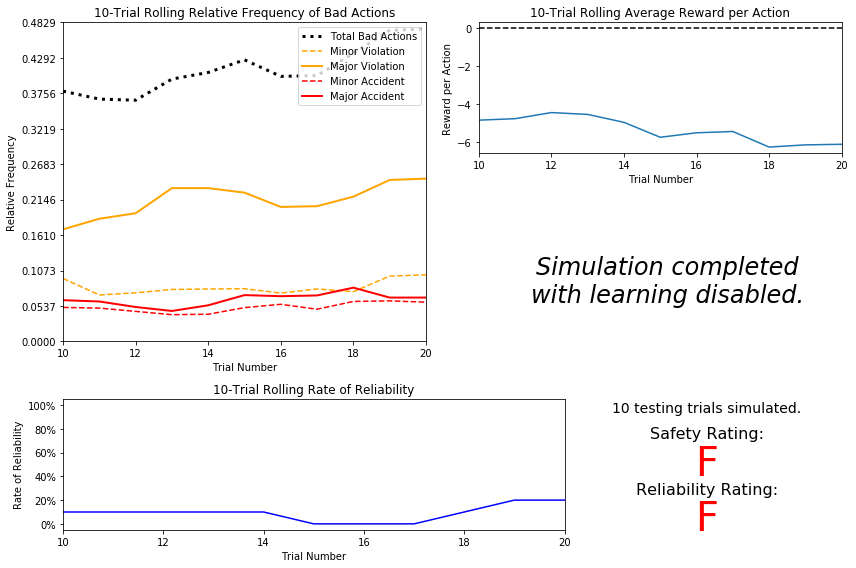

In [4]:
# Load the 'sim_no-learning' log file from the initial simulation results
vs.plot_trials('sim_no-learning.csv')

### Question 3
Using the visualization above that was produced from your initial simulation, provide an analysis and make several observations about the driving agent. Be sure that you are making at least one observation about each panel present in the visualization. Some things you could consider:
- *How frequently is the driving agent making bad decisions? How many of those bad decisions cause accidents?*
- *Given that the agent is driving randomly, does the rate of reliability make sense?*
- *What kind of rewards is the agent receiving for its actions? Do the rewards suggest it has been penalized heavily?*
- *As the number of trials increases, does the outcome of results change significantly?*
- *Would this Smartcab be considered safe and/or reliable for its passengers? Why or why not?*

**Answer:**
- From the 10 trial relative rolling frequency of Bad actions we find:
    * the agent makes bad decisions around 40% of the time
    * 5% of the of the decisions leads to a major accident, which means 12.5 % of all bad decisions lead to a major accident.
    * approximately the same number of minor accidents occur
    * this means that 25 % of the bad decisions lead to an accident either major or minor. this means that for every bad decision the agent takes there is a 1/4 chance that it caused an accident of some form
- From the rolling rate of reliabilty we find:
    * the agent achieves success approximately 15-20% of the time. this means that the agent arrives to the destination correctly on random around 20% of the time.
- From the rolling average of rewards we find that the average reward for the agent is around -5. from the frequency of bad decisions we found that the agent does around 5% major accidents which should give scores of -40 and 20% major violations which should cause rewards of -10. given that the average reward is -5 we can conclude that the agent also recieves good rewards for its actions and is not majorly penalized in general. a score of -5 is more in tune with a minor violation all the time.
- The outcomes of the agent doesnt change significantly with an increase in number of trials. this is expected since the agent isnt learning or changing the behaviour. the entire trial is always random so the constant results makes sense here.
- The smartcab is definitely not safe or reliable for passengers. the metric for safety has been defined to have no major accidents and very low number of minor violations. the smartcab currently has 5% chances of creating a major accident in the simulation. The reliability of the cab has been defined as whether the cab reaches its target > 90 % of the time. right now the cab only reaches 20% of the time. I have chosen to compare it to the highest grades possible in reliability and safety because in a real world situation achieving less that A+ grades in the real world make the car too unsafe to be used publicly

-----
## Inform the Driving Agent
The second step to creating an optimized Q-learning driving agent is defining a set of states that the agent can occupy in the environment. Depending on the input, sensory data, and additional variables available to the driving agent, a set of states can be defined for the agent so that it can eventually *learn* what action it should take when occupying a state. The condition of `'if state then action'` for each state is called a **policy**, and is ultimately what the driving agent is expected to learn. Without defining states, the driving agent would never understand which action is most optimal -- or even what environmental variables and conditions it cares about!

### Identify States
Inspecting the `'build_state()'` agent function shows that the driving agent is given the following data from the environment:
- `'waypoint'`, which is the direction the *Smartcab* should drive leading to the destination, relative to the *Smartcab*'s heading.
- `'inputs'`, which is the sensor data from the *Smartcab*. It includes 
  - `'light'`, the color of the light.
  - `'left'`, the intended direction of travel for a vehicle to the *Smartcab*'s left. Returns `None` if no vehicle is present.
  - `'right'`, the intended direction of travel for a vehicle to the *Smartcab*'s right. Returns `None` if no vehicle is present.
  - `'oncoming'`, the intended direction of travel for a vehicle across the intersection from the *Smartcab*. Returns `None` if no vehicle is present.
- `'deadline'`, which is the number of actions remaining for the *Smartcab* to reach the destination before running out of time.

### Question 4
*Which features available to the agent are most relevant for learning both **safety** and **efficiency**? Why are these features appropriate for modeling the *Smartcab* in the environment? If you did not choose some features, why are those features* not *appropriate? Please note that whatever features you eventually choose for your agent's state, must be argued for here. That is: your code in agent.py should reflect the features chosen in this answer.
*

NOTE: You are not allowed to engineer new features for the smartcab. 

**Answer:**
* Safety: -- inputs : light - The light state is critical to safety so that the algorithm can conform to traffic regulations. In particular, the smartcab should stop at a red light. -- inputs : left/right/oncoming - The direction of travel for other traffic is vital to determine whether it's safe to proceed, otherwise a collision could result.
* Efficiency -- waypoint - The waypoint is most appropriate for achieving efficiency. This will ensure the smartcab reaches the destination in the most efficient manner possible.<br>
<br>
The deadline has not been included as part of the learning process. Whilst meeting the deadline is important, there are not any<br> complementing parameters that could be used to help meet this deadline - apart from ignoring other vehicles and traffic<br> lights, which would compromise safety. The only thing that could be used here is improving the pathfinding as part<br> of the waypoint.<br>
<br>
Including deadline could also add another dimension to our q-matrix, causing our state space to increase and take a much longer<br> time to converge.<br>

### Define a State Space
When defining a set of states that the agent can occupy, it is necessary to consider the *size* of the state space. That is to say, if you expect the driving agent to learn a **policy** for each state, you would need to have an optimal action for *every* state the agent can occupy. If the number of all possible states is very large, it might be the case that the driving agent never learns what to do in some states, which can lead to uninformed decisions. For example, consider a case where the following features are used to define the state of the *Smartcab*:

`('is_raining', 'is_foggy', 'is_red_light', 'turn_left', 'no_traffic', 'previous_turn_left', 'time_of_day')`.

How frequently would the agent occupy a state like `(False, True, True, True, False, False, '3AM')`? Without a near-infinite amount of time for training, it's doubtful the agent would ever learn the proper action!

### Question 5
*If a state is defined using the features you've selected from **Question 4**, what would be the size of the state space? Given what you know about the environment and how it is simulated, do you think the driving agent could learn a policy for each possible state within a reasonable number of training trials?*  
**Hint:** Consider the *combinations* of features to calculate the total number of states!

**Answer:**
* First, we must consider each feature, and the number of states each one has:
    - waypoint - [left, right, forward] : 3
    - inputs-light - [red, green] : 2
    - inputs-left - [left, right, forward, None] : 4
    - inputs-right - [left, right, forward, None] : 4
    - inputs-oncoming - [left, right, forward, None] : 4
<br>
* This results in a total number of 3 x 2 x 4 x 4 x 4 = 384 states. This is quite a lot of states, and will require a good quantity of trials to learn effectively. Given a simulation running for 100 trips, each taking about 10-20 moves, it will mean a significant amount of trips will be required to learn fully, though still in the realm of practicality.
<br>
* For a US-traffic laws, inputs-left turning 'right' could actually be omitted/combined because it has no bearing on the learning agent. However, this state has not been removed from the model so that it could be applied to left-hand drive traffic laws too.

### Update the Driving Agent State
For your second implementation, navigate to the `'build_state()'` agent function. With the justification you've provided in **Question 4**, you will now set the `'state'` variable to a tuple of all the features necessary for Q-Learning. Confirm your driving agent is updating its state by running the agent file and simulation briefly and note whether the state is displaying. If the visual simulation is used, confirm that the updated state corresponds with what is seen in the simulation.

**Note:** Remember to reset simulation flags to their default setting when making this observation!

-----
## Implement a Q-Learning Driving Agent
The third step to creating an optimized Q-Learning agent is to begin implementing the functionality of Q-Learning itself. The concept of Q-Learning is fairly straightforward: For every state the agent visits, create an entry in the Q-table for all state-action pairs available. Then, when the agent encounters a state and performs an action, update the Q-value associated with that state-action pair based on the reward received and the iterative update rule implemented. Of course, additional benefits come from Q-Learning, such that we can have the agent choose the *best* action for each state based on the Q-values of each state-action pair possible. For this project, you will be implementing a *decaying,* $\epsilon$*-greedy* Q-learning algorithm with *no* discount factor. Follow the implementation instructions under each **TODO** in the agent functions.

Note that the agent attribute `self.Q` is a dictionary: This is how the Q-table will be formed. Each state will be a key of the `self.Q` dictionary, and each value will then be another dictionary that holds the *action* and *Q-value*. Here is an example:

```
{ 'state-1': { 
    'action-1' : Qvalue-1,
    'action-2' : Qvalue-2,
     ...
   },
  'state-2': {
    'action-1' : Qvalue-1,
     ...
   },
   ...
}
```

Furthermore, note that you are expected to use a *decaying* $\epsilon$ *(exploration) factor*. Hence, as the number of trials increases, $\epsilon$ should decrease towards 0. This is because the agent is expected to learn from its behavior and begin acting on its learned behavior. Additionally, The agent will be tested on what it has learned after $\epsilon$ has passed a certain threshold (the default threshold is 0.05). For the initial Q-Learning implementation, you will be implementing a linear decaying function for $\epsilon$.

### Q-Learning Simulation Results
To obtain results from the initial Q-Learning implementation, you will need to adjust the following flags and setup:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file and the Q-table as a `.txt` file in `/logs/`.
- `'n_test'` - Set this to `'10'` to perform 10 testing trials.
- `'learning'` - Set this to `'True'` to tell the driving agent to use your Q-Learning implementation.

In addition, use the following decay function for $\epsilon$:

$$ \epsilon_{t+1} = \epsilon_{t} - 0.05, \hspace{10px}\textrm{for trial number } t$$

If you have difficulty getting your implementation to work, try setting the `'verbose'` flag to `True` to help debug. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation! 

Once you have successfully completed the initial Q-Learning simulation, run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!

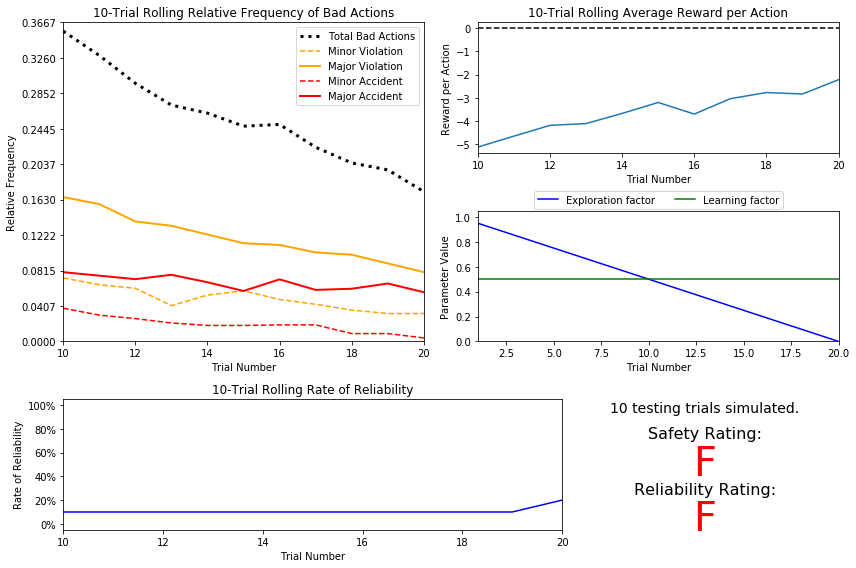

In [5]:
# Load the 'sim_default-learning' file from the default Q-Learning simulation
vs.plot_trials('sim_default-learning.csv')

### Question 6
Using the visualization above that was produced from your default Q-Learning simulation, provide an analysis and make observations about the driving agent like in **Question 3**. Note that the simulation should have also produced the Q-table in a text file which can help you make observations about the agent's learning. Some additional things you could consider:  
- *Are there any observations that are similar between the basic driving agent and the default Q-Learning agent?*
- *Approximately how many training trials did the driving agent require before testing? Does that number make sense given the epsilon-tolerance?*
- *Is the decaying function you implemented for $\epsilon$ (the exploration factor) accurately represented in the parameters panel?*
- *As the number of training trials increased, did the number of bad actions decrease? Did the average reward increase?*
- *How does the safety and reliability rating compare to the initial driving agent?*

**Answer:**
- According to the 10 trial rolling relative frequency of bad actions we find:
    * the total number of bad actions has decreased from 40% for the basic agent to near 12% in the learnt agent.
    * the number of major accidents is still around 4% which means that bad decisions taken by the learnt agent are more likely to lead to a major accident. but the learning agent takes relatively less bad actions.
- According to the rolling average reward graph we find that the agent is now recieving an average of around 0 points per decision, this is an improvement of 5 points from the basic agent.
- According to the rate of reliability we find that agent achieves around 80% reliability by the end of 20 trials as compared to the 20% of the basic agent.
- since the epsilon function was a linear decay of 0.05 it would take 20 trials for the epsilon to decay from 1 to 0. this is accurately captured in the epsilon factor - learning factor graph by a straight line going from 1 to 0. the initial value is 0.8 because the epsilon is calculated in the reset function which is called before every trial including the first one.
- the driving agent is significantly safer and more reliable than the basic agent, which achieved F in both the reliability and the safety. This agent achieves a grade D in safety and a grade A+ in reliability. which means its still very unsafe to drive in this car and is likely to reach the destination 90% of the time in the 10 test trials.
- when running the agent in a 100 test trial, the overall performance seems to decrease quite a bit, it still acheives a very high reliability of A and a F score in safety. This suggests that the learner hasnt learnt all the safety rules of the road, since it led to a major accident atleast once. This driver cannot be used for a real life scenario.

-----
## Improve the Q-Learning Driving Agent
The third step to creating an optimized Q-Learning agent is to perform the optimization! Now that the Q-Learning algorithm is implemented and the driving agent is successfully learning, it's necessary to tune settings and adjust learning paramaters so the driving agent learns both **safety** and **efficiency**. Typically this step will require a lot of trial and error, as some settings will invariably make the learning worse. One thing to keep in mind is the act of learning itself and the time that this takes: In theory, we could allow the agent to learn for an incredibly long amount of time; however, another goal of Q-Learning is to *transition from experimenting with unlearned behavior to acting on learned behavior*. For example, always allowing the agent to perform a random action during training (if $\epsilon = 1$ and never decays) will certainly make it *learn*, but never let it *act*. When improving on your Q-Learning implementation, consider the implications it creates and whether it is logistically sensible to make a particular adjustment.

### Improved Q-Learning Simulation Results
To obtain results from the initial Q-Learning implementation, you will need to adjust the following flags and setup:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file and the Q-table as a `.txt` file in `/logs/`.
- `'learning'` - Set this to `'True'` to tell the driving agent to use your Q-Learning implementation.
- `'optimized'` - Set this to `'True'` to tell the driving agent you are performing an optimized version of the Q-Learning implementation.

Additional flags that can be adjusted as part of optimizing the Q-Learning agent:
- `'n_test'` - Set this to some positive number (previously 10) to perform that many testing trials.
- `'alpha'` - Set this to a real number between 0 - 1 to adjust the learning rate of the Q-Learning algorithm.
- `'epsilon'` - Set this to a real number between 0 - 1 to adjust the starting exploration factor of the Q-Learning algorithm.
- `'tolerance'` - set this to some small value larger than 0 (default was 0.05) to set the epsilon threshold for testing.

Furthermore, use a decaying function of your choice for $\epsilon$ (the exploration factor). Note that whichever function you use, it **must decay to **`'tolerance'`** at a reasonable rate**. The Q-Learning agent will not begin testing until this occurs. Some example decaying functions (for $t$, the number of trials):

$$ \epsilon = a^t, \textrm{for } 0 < a < 1 \hspace{50px}\epsilon = \frac{1}{t^2}\hspace{50px}\epsilon = e^{-at}, \textrm{for } 0 < a < 1 \hspace{50px} \epsilon = \cos(at), \textrm{for } 0 < a < 1$$
You may also use a decaying function for $\alpha$ (the learning rate) if you so choose, however this is typically less common. If you do so, be sure that it adheres to the inequality $0 \leq \alpha \leq 1$.

If you have difficulty getting your implementation to work, try setting the `'verbose'` flag to `True` to help debug. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation! 

Once you have successfully completed the improved Q-Learning simulation, run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!

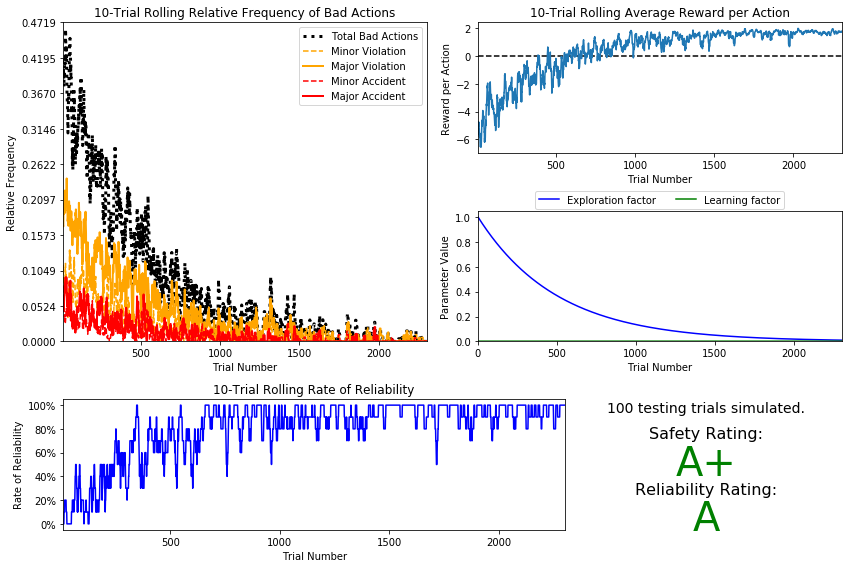

In [6]:
# Load the 'sim_improved-learning' file from the improved Q-Learning simulation
vs.plot_trials('sim_improved-learning.csv')

### Question 7
Using the visualization above that was produced from your improved Q-Learning simulation, provide a final analysis and make observations about the improved driving agent like in **Question 6**. Questions you should answer:  
- *What decaying function was used for epsilon (the exploration factor)?*
- *Approximately how many training trials were needed for your agent before begining testing?*
- *What epsilon-tolerance and alpha (learning rate) did you use? Why did you use them?*
- *How much improvement was made with this Q-Learner when compared to the default Q-Learner from the previous section?*
- *Would you say that the Q-Learner results show that your driving agent successfully learned an appropriate policy?*
- *Are you satisfied with the safety and reliability ratings of the *Smartcab*?*

**Answer:**
* An epsilon = e^(-at) decay function was used, with epsilon starting at 1.00. This was picked because it is important to have a great wealth of learning early on, with a gradual decline into exploration.
* Approximately 2500 trials were needed before testing was completed.
* An epsilon tolerance of 0.01 was used, and an alpha of 0.02. The very low alpha was used to allow the model sufficient trials to train with, and caused the ~2500 of trials. A large number of trials is important to increase the safety rating to a maximum. As a result of the small alpha, a smaller tolerance is more appropriate - otherwise a large proportion of trials towards the end of the decay would be missed.
* A large improvement has been made from the Q-Learner from the previous section. 
    * The Safety Rating has increased from an F to an A+
    * The Reliability Rating has increased from an F to an A.
    * These are both significant improvements that would deem the Smartcab safe for deployment.
* The very good rating in smartcab performance indicates that the Q-Learner has successfully learned the policy, even after 100 test runs
* The Q-Learner seems to converge towards 1750-2000 trials, and additional learnings are helpful but also minimal
* Overall, the ratings of the Smartcab are satisfactory and the decision making seems appropriate for deployment for the context of this tightly controlled simulation. In a real-world driving environment, traffic rules are clearly much more complex and the state space would be much larger.

### Define an Optimal Policy

Sometimes, the answer to the important question *"what am I trying to get my agent to learn?"* only has a theoretical answer and cannot be concretely described. Here, however, you can concretely define what it is the agent is trying to learn, and that is the U.S. right-of-way traffic laws. Since these laws are known information, you can further define, for each state the *Smartcab* is occupying, the optimal action for the driving agent based on these laws. In that case, we call the set of optimal state-action pairs an **optimal policy**. Hence, unlike some theoretical answers, it is clear whether the agent is acting "incorrectly" not only by the reward (penalty) it receives, but also by pure observation. If the agent drives through a red light, we both see it receive a negative reward but also know that it is not the correct behavior. This can be used to your advantage for verifying whether the **policy** your driving agent has learned is the correct one, or if it is a **suboptimal policy**.

### Question 8

1. Please summarize what the optimal policy is for the smartcab in the given environment. What would be the best set of instructions possible given what we know about the environment? 
   _You can explain with words or a table, but you should thoroughly discuss the optimal policy._

2. Next, investigate the `'sim_improved-learning.txt'` text file to see the results of your improved Q-Learning algorithm. _For each state that has been recorded from the simulation, is the **policy** (the action with the highest value) correct for the given state? Are there any states where the policy is different than what would be expected from an optimal policy?_ 

3. Provide a few examples from your recorded Q-table which demonstrate that your smartcab learned the optimal policy. Explain why these entries demonstrate the optimal policy.

4. Try to find at least one entry where the smartcab did _not_ learn the optimal policy.  Discuss why your cab may have not learned the correct policy for the given state.

Be sure to document your `state` dictionary below, it should be easy for the reader to understand what each state represents.

**Answer:** 
the state space i defined is of the form (waypoint, light, oncoming) the expected optimal policy for the algorithm should have a few essential features:<br>
1. any movement in a red light state should have the largest negative penalty. This would mean the agent has learnt the most basic traffic rule.<br>
    eg. the agent in a state (forward, 'red', forward) shoud have None as the max Q action.<br>
    * since we ignored the state of left, the agent will not have reliably learnt the right turn rule of the traffic, where it is allowed to take right on a red light if there is no oncoming traffic from the left side.<br>
    eg. the agent in state (right, 'red' , forward) and (right, 'red', 'left') should not have much difference and will likely just stay idle.
2. vice versa most of the states in the 'green' light should encourage movement, but certain conditions should be satisfied.
    * if the oncoming traffic is in a direction which will cause a collision, the action should be avoided.<br>
    eg. the agent in a state (forward, 'green', backward) should have the highest Q state in either left of right.<br>
    * if the oncoming traffic is in the same direction as the waypoint, the waypoint direction should be given preference.<br>
    eg. the agent in a state (forward, green, forward) should be ok with going forward, since it will not cause a collision and will get them closer to the destination<br>
    
    the agent should however learn the left turn rule, where it is not allowed to turn left if the oncoming traffic is turning right.<br>

    eg. the agent in a state (left, green, right) should have a heavy penalty on the left action.<br>

The policy which was created by the learner displays the following states:<br>
('forward', 'red', 'forward')<br>
 -- forward : -4.87<br>
 -- right : -10.01<br>
 -- None : 1.52<br>
 -- left : 0.00<br>
This seems correct for the reasons stated above.<br>
('forward', 'green', 'forward')<br>
 -- forward : 1.35<br>
 -- right : 0.22<br>
 -- None : 0.00<br>
 -- left : -15.18<br>
This seems correct for the reasons stated above.<br>
('right', 'red', None)<br>
 -- forward : -19.93<br>
 -- right : -8.79<br>
 -- None : 1.46<br>
 -- left : 0.00<br>
('right', 'red', 'forward')<br>
 -- forward : -4.90<br>
 -- right : 0.00<br>
 -- None : 1.56<br>
 -- left : -22.54<br>
('right', 'red', 'right')<br>
 -- forward : 0.00<br>
 -- right : 0.00<br>
 -- None : 1.69<br>
 -- left : 0.00<br>
As stated above on the red light, when the agent wants to turn right, it has no idea about the right turn rule.<br>
('left', 'green', 'right')<br>
 -- forward : 1.22<br>
 -- right : 0.00<br>
 -- None : 0.00<br>
 -- left : 0.00<br>
As stated the agent have actually effectively learnt the left turning rule here, but it isnt very clear if it was unintentional,<br> this however does obey the traffic safety rule.<br>
It should be noted that the learner learns very negative rewards for actions that would create a major traffic accident. this is<br> why it has managed to avoid getting into any accident even in the 100 trial run.<br>
Looking through the learner states, we see that most of the state action pairs have some value, thus the learner did get to<br> notice sufficient states during the exploration state to make informed decisions about the world.<br>

-----
### Optional: Future Rewards - Discount Factor, `'gamma'`
Curiously, as part of the Q-Learning algorithm, you were asked to **not** use the discount factor, `'gamma'` in the implementation. Including future rewards in the algorithm is used to aid in propagating positive rewards backwards from a future state to the current state. Essentially, if the driving agent is given the option to make several actions to arrive at different states, including future rewards will bias the agent towards states that could provide even more rewards. An example of this would be the driving agent moving towards a goal: With all actions and rewards equal, moving towards the goal would theoretically yield better rewards if there is an additional reward for reaching the goal. However, even though in this project, the driving agent is trying to reach a destination in the allotted time, including future rewards will not benefit the agent. In fact, if the agent were given many trials to learn, it could negatively affect Q-values!

### Optional Question 9
*There are two characteristics about the project that invalidate the use of future rewards in the Q-Learning algorithm. One characteristic has to do with the *Smartcab* itself, and the other has to do with the environment. Can you figure out what they are and why future rewards won't work for this project?*

**Answer:**
- even though we are given a deadline metric, the agent does not know where the destination is, it only knows what is the next waypoint to reach. given this, it makes it impossible for the agent to learn good routes to the destination and thus taking future rewards does not benefit.
- in each simulation the destination of the agent keeps changing, a route that was followed before while gaining good future rewards in a previous trial may be completely invalid in this scenario.
- if the simulation had a variation in the road sizes, specific places with high density traffic like the real world, perhaps accounting for future rewards may be considered useful.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.